In [1]:
%matplotlib inline
import nengo.spa as spa
import numpy as np
import matplotlib.pyplot as plt

First, here's the SPA power function:

In [2]:
def power(s, e):
    x = np.fft.ifft(np.fft.fft(s.v) ** e).real
    return spa.SemanticPointer(data=x)


Here are two helper functions for computing the dot product over space, and for plotting the results

In [8]:
def spatial_dot(v, X, Y, xs, ys, transform=1):
    if isinstance(v, spa.SemanticPointer):
        v = v.v
    vs = np.zeros((len(ys),len(xs)))
    for i,x in enumerate(xs):
        for j, y in enumerate(ys):
            t = power(X, x)*power(Y,y)*transform
            vs[j,i] = np.dot(v, t.v)
    return vs

def spatial_plot(vs):
    vs = vs[::-1, :]
    plt.imshow(vs, interpolation='none', extent=(xs[0],xs[-1],ys[0],ys[-1]), vmax=1, vmin=-1, cmap='plasma')
    plt.colorbar()
        

Let's do a quick example of using the above functions to represent two items at (2,1.3) and (0,0.7)

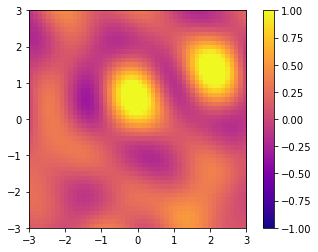

In [5]:
D = 64
X = spa.SemanticPointer(D)
X.make_unitary()
Y = spa.SemanticPointer(D)
Y.make_unitary()
xs = np.linspace(-3, 3, 50)
ys = np.linspace(-3, 3, 50)


v = power(X,2)*power(Y,1.3) + power(X,0)*power(Y,0.7)
vs = spatial_dot(v, X, Y, xs, ys)
spatial_plot(vs)

So, that lets us take a vector and turn it into a spatial map.  Now let's try going the other way around: specify a desired map, and find the vector that gives that.

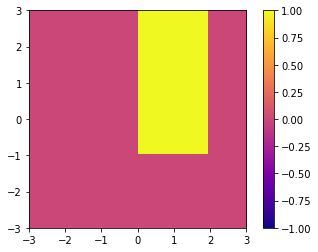

In [6]:
desired = np.zeros((len(xs),len(ys)))
for i,x in enumerate(xs):
    for j, y in enumerate(ys):
        if 0<x<2 and -1<y<=3:
            val = 1
        else:
            val = 0
        desired[j, i] = val
        
spatial_plot(desired)


This can be treated as a least-sqares minimization problem.  In paticular, we're trying to build the above map using a basis space.  The basis vectors in that space are *the spatial maps of the D unit vectors in our vector space*!!  So let's compute those, and use our standard nengo solver:

In [19]:
A = np.array([spatial_dot(np.eye(D)[i], X, Y, xs, ys).flatten() for i in range(D)])

In [45]:
import nengo
v, info = nengo.solvers.LstsqL2(reg=0)(np.array(A).T, desired.flatten())

0.15430118770275075


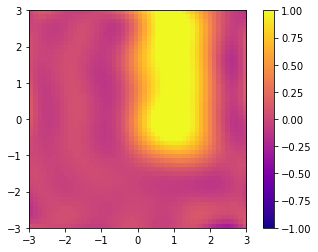

In [46]:
vs = spatial_dot(v, X, Y, xs, ys)
rmse = np.sqrt(np.mean((vs-desired)**2))
print(rmse)
spatial_plot(vs)

Yay!

However, one possible problem with this approach is that the norm of this vector is unconstrained:

In [47]:
np.linalg.norm(v)

62.201013711160165

A better solution would add a constraint on the norm.